In [ ]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
from nltk.corpus import stopwords
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [ ]:
EMBEDDING_DIM = 16
EPOCHS = 5
MAX_LEN = 32
MAX_WORDS = 20000

TEST_SIZE = 0.2
PROBABILITY_THRESHOLD = 0.5

In [ ]:
PATH_DATASET = "./kaggle/spam.csv"

In [ ]:
dataset = pd.read_csv(
    PATH_DATASET,
    encoding="ISO-8859-1",
    usecols=[0, 1],
    skiprows=1,
    names=["label", "message"],
)
dataset.label = dataset.label.map({"ham": 0, "spam": 1})

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    dataset.message, dataset.label, test_size=TEST_SIZE
)

In [ ]:
# Tentando remover palavras comuns como "the", "a", "an", "in", etc
nltk.download("stopwords")
stop = set(stopwords.words("english"))


# https://stackoverflow.com/questions/5486337/how-to-remove-stop-words-using-nltk-or-python
def remove_stopwords(text: str):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

In [ ]:
dataset["message"] = dataset.message.map(remove_stopwords)

In [ ]:
# TODO: should we actually use num_unique_words as max_tokens? There's going to be more data adter the training
vectorizer = layers.TextVectorization(
    max_tokens=MAX_WORDS,
    output_mode="int",
    output_sequence_length=MAX_LEN,
    encoding="ISO-8859-1",
)

In [ ]:
vectorizer.adapt(x_train.to_numpy())

In [ ]:
model = keras.Sequential()
model.add(vectorizer)
model.add(layers.Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(layers.Flatten())
model.add(layers.Dense(24, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

In [1]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 32)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 32, 16)            320000    
                                                                 
 bidirectional (Bidirectiona  (None, 32, 128)          41472     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                        

In [ ]:
optimizer = keras.optimizers.Adam()
loss = keras.losses.BinaryCrossentropy()
metrics = keras.metrics.BinaryAccuracy()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [2]:
# Treinando o modelo

history = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
)

Epoch 1/5
140/140 [==============================] - 8s 25ms/step - loss: 0.1795 - binary_accuracy: 0.9396
Epoch 2/5
140/140 [==============================] - 4s 25ms/step - loss: 0.0294 - binary_accuracy: 0.9933
Epoch 3/5
140/140 [==============================] - 4s 25ms/step - loss: 0.0151 - binary_accuracy: 0.9955
Epoch 4/5
140/140 [==============================] - 4s 26ms/step - loss: 0.0074 - binary_accuracy: 0.9980
Epoch 5/5
140/140 [==============================] - 4s 26ms/step - loss: 0.0028 - binary_accuracy: 0.9993


In [3]:
# Perda e Acurácia
loss, accuracy = model.evaluate(x_test, y_test)
print("Perda:", loss)
print("Acurácia:", accuracy)

35/35 [==============================] - 1s 11ms/step - loss: 0.1223 - binary_accuracy: 0.9776
Perda: 0.1223192811012268
Acurácia: 0.9775784611701965


In [4]:
# Fazendo predições para os dados de teste

predictions_prob = model.predict(x_test)
predictions = [1 if p > PROBABILITY_THRESHOLD else 0 for p in predictions_prob]

35/35 [==============================] - 1s 12ms/step


In [5]:
# Criando a matrix de confusão para precisão e recall

confusion_matrix = tf.math.confusion_matrix(labels=y_test, predictions=predictions)
confusion_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[955,  14],
       [ 11, 135]], dtype=int32)>

In [6]:
# Percentagem do total de spams detectados i.e., recall

recall = keras.metrics.Recall()
recall.update_state(y_test, predictions)
recall_score = recall.result().numpy()
print("Recall:", recall_score)

Recall: 0.9246575


In [7]:
# Percentagem das predições positivas (spams) corretas, i.e. precisão

precision = keras.metrics.Precision()
precision.update_state(y_test, predictions)
precision_score = precision.result().numpy()

print("Precisão:", precision_score)

Precisão: 0.90604025


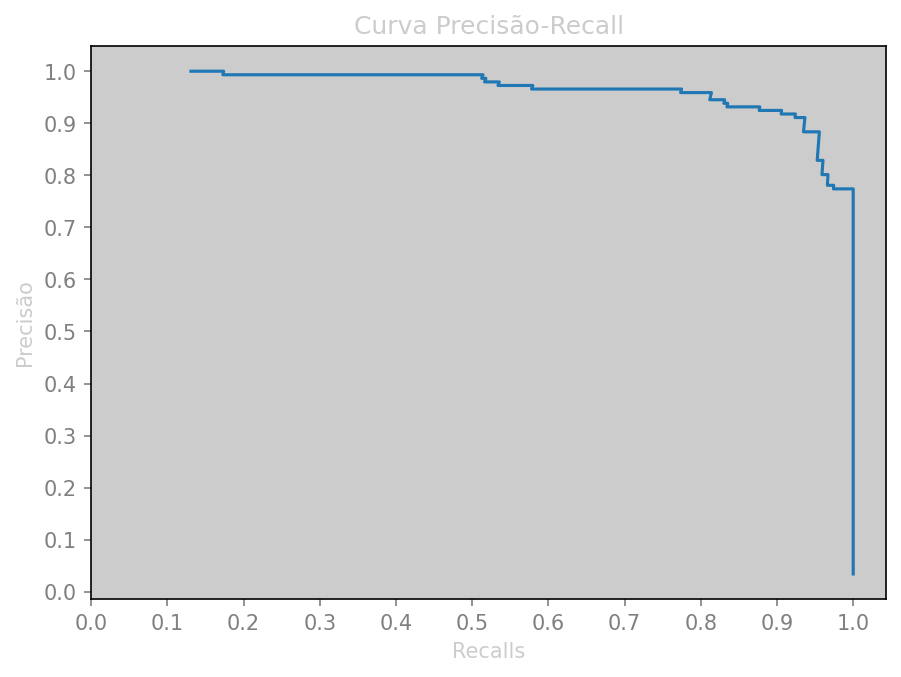

In [8]:
# Plotando a curva precisão-recall

precisions, recalls, _ = precision_recall_curve(y_test, predictions_prob)

plt.figure(figsize=(10, 7))
plt.plot(precisions[:-1], recalls[:-1])
plt.xlabel("Recalls")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Precisão")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Curva Precisão-Recall")
plt.show()

In [9]:
# Exemplo de predição

sample_text = ["WINNER. You won this exciting lottery!!!"]
sample_input = pd.Series(sample_text)
sample_prob = model.predict(sample_input)
sample_pred = "SPAM" if sample_prob[0] > PROBABILITY_THRESHOLD else "HAM"
sample_pred

1/1 [==============================] - 0s 18ms/step


'SPAM'